Assumptions Made:
1. Demand was given as poisson distribution. Ideally since it is poisson distribution it can go until infinity. But an upper limit of 100 (Max Inventory) was used as upper limit of demand. This is reasonable since this value much higher than average value of demand of each month. Hence probablity of acheiving values greater than 100 will be very less.
2. Actions taken in Month m was attributed to the previous month's state for ease of modelling. So if an action is taken in Oct to by x skis, it would be considered as action for the month of Sep

In [291]:
import numpy as np
import  matplotlib.pyplot as plt
from scipy.stats import poisson

In [292]:
class SkiInventory:
    def __init__(self, inventory_max, wholesale_cost, retail_cost, fire_sale_cost, average_demand, discount_factor):
        self.inventory_max = inventory_max
        self.wholesale_cost = wholesale_cost
        self.retail_cost = retail_cost
        self.fire_sale_cost = fire_sale_cost

        self.discount_factor = discount_factor
        self.months = ['Sep', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar']
        self.average_demand = {}
        for i in range(1, len(self.months)):
            self.average_demand[self.months[i]] = average_demand[i - 1]

        # self.value = {}
        # for i in range(len(self.months)):
        #     self.value[self.months[i]] = np.zeros(self.inventory_max + 1)
        self.state_value = np.zeros((len(self.months), self.inventory_max + 1))
        self.state_action_value = np.zeros((len(self.months), self.inventory_max + 1, self.inventory_max+1))
        self.optimal_policy = np.zeros_like(self.state_value)
        # self.value = [[0]]
        # for i in range(len(self.months) - 1):
        #     self.value.append([0]*(self.inventory_max + 1))

    def get_next_month(self, cur_month):
        months = iter(self.average_demand)
        cur_month in months
        return next(months, False)

    def step(self, state, action, demand):
        cur_month = state[0]
        cur_month_index = self.months.index(cur_month)
        inventory = state[1]
        updated_inventory = min(self.inventory_max, inventory + action)
        next_month = self.months[cur_month_index + 1]
        num_sold = min(updated_inventory, demand)
        reward = num_sold*self.retail_cost - action*self.wholesale_cost
        new_inventory = int(updated_inventory - num_sold)
        if next_month == 'Mar':
            reward += new_inventory*self.fire_sale_cost
            new_inventory = 0
        new_state = [next_month, new_inventory]
        return new_state, reward


    def get_state_value(self, policy):

        while True:
            new_value = np.zeros_like(self.state_value)
            for cur_month in range(len(self.months) - 1):
                if cur_month == 0:
                    inventory_limit = 0
                else:
                    inventory_limit = self.inventory_max
                for inventory in range(inventory_limit+1):
                    actions, actions_prob = policy(cur_month, inventory)
                    for i, action in enumerate(actions):
                        if inventory + action > self.inventory_max:
                            break
                        for demand in range(self.inventory_max):
                            new_state, reward = self.step([self.months[cur_month], inventory], action, demand)
                            new_value[cur_month, inventory] += actions_prob[i] * poisson.pmf(demand, self.average_demand[self.months[cur_month + 1]])*(reward + self.discount_factor*self.state_value[cur_month+1, new_state[1]])

            print("Error : " +str(np.sum(np.abs(self.state_value - new_value))))
            if np.sum(np.abs(self.state_value - new_value)) < 1e-4:
                break

            self.state_value = new_value

    def get_state_action_value(self, policy):

        while True:
            new_state_action_value = np.zeros_like(self.state_action_value)
            for cur_month in range(len(self.months) - 1):
                if cur_month == 0:
                    inventory_limit = 0
                else:
                    inventory_limit = self.inventory_max
                for inventory in range(inventory_limit+1):
                    # actions, actions_prob = policy(cur_month + 1, inventory)

                    # for i, action in enumerate(actions):
                    for action in range(self.inventory_max+1):
                        if inventory + action > self.inventory_max:
                            break
                        for demand in range(self.inventory_max):
                            new_state, reward = self.step([self.months[cur_month], inventory], action, demand)
                            # next_value = np.max(self.state_action_value[cur_month+1, new_state[1]])

                            new_state_action_value[cur_month, inventory, int(action)] += poisson.pmf(demand, self.average_demand[self.months[cur_month + 1]])*(reward + self.discount_factor*self.state_value[cur_month+1, new_state[1]])
                            # print(poisson.pmf(demand, self.average_demand[self.months[cur_month + 1]])*(reward + self.discount_factor*next_value))
                        #
            new_state_value = np.zeros_like(self.state_value)
            for cur_month in range(len(self.months) - 1):
                if cur_month == 0:
                    inventory_limit = 0
                else:
                    inventory_limit = self.inventory_max
                for inventory in range(inventory_limit+1):
                    actions, actions_prob = policy(cur_month, inventory)

                    for i, action in enumerate(actions):
                        new_state_value[cur_month, inventory] +=  actions_prob[i] * new_state_action_value[cur_month, inventory, int(action)]

            print("Error : " +str(np.sum(np.abs(self.state_action_value - new_state_action_value))))
            if np.sum(np.abs(self.state_action_value - new_state_action_value)) < 1e-4:
                break

            self.state_action_value = new_state_action_value
            self.state_value = new_state_value

    def optimal_policy_prob(self, cur_month, cur_inventory):

        actions_prob = [1]
        actions = [self.optimal_policy[cur_month, cur_inventory]]
        return actions, actions_prob

    def get_optimal_policy(self):

        # if state_value:
        for cur_month in range(len(self.months) - 1):
            if cur_month == 0:
                inventory_limit = 0
            else:
                inventory_limit = self.inventory_max
            for inventory in range(inventory_limit+1):
                action_returns = []
                for action in range(self.inventory_max + 1):
                    if inventory + action > self.inventory_max:
                        action_returns.append(-np.inf)
                        continue
                    cur_action = 0
                    for demand in range(self.inventory_max):
                        new_state, reward = self.step([self.months[cur_month], inventory], action, demand)
                        # next_value = np.max(self.state_action_value[cur_month+1, new_state[1]])

                        cur_action += poisson.pmf(demand, self.average_demand[self.months[cur_month + 1]])*(reward + self.discount_factor*self.state_value[cur_month+1, new_state[1]])
                    action_returns.append(cur_action)
                self.optimal_policy[cur_month, inventory] = np.argmax(action_returns)

        # else:
        #     for cur_month in range(len(self.months) - 1):
        #         if cur_month == 0:
        #             inventory_limit = 0
        #         else:
        #             inventory_limit = self.inventory_max
        #         for inventory in range(inventory_limit+1):
        #             self.optimal_policy[cur_month, inventory] = np.argmax(self.state_action_value[cur_month, inventory])

    def policy_iteration(self):
        # if state_value:
        while True:
            prev_policy = self.optimal_policy.copy()
            self.get_state_value(self.optimal_policy_prob)
            self.get_optimal_policy()
            print(np.sum(np.abs(self.optimal_policy - prev_policy)))
            if np.sum(np.abs(self.optimal_policy - prev_policy)) < 1e-4:
                print("Optimal Policy Found")
                break
        # else:
        #     while True:
        #         prev_policy = self.optimal_policy.copy()
        #         self.get_state_action_value(self.optimal_policy_prob)
        #         self.get_optimal_policy(state_value)
        #         print(np.sum(np.abs(self.optimal_policy - prev_policy)))
        #         if np.sum(np.abs(self.optimal_policy - prev_policy)) < 1e-4:
        #             print("Optimal Policy Found")
        #             break

    def value_iteration(self):

        while True:
            new_value = np.zeros_like(self.state_value)
            for cur_month in range(len(self.months) - 1):
                if cur_month == 0:
                    inventory_limit = 0
                else:
                    inventory_limit = self.inventory_max
                for inventory in range(inventory_limit+1):
                    action_returns = []
                    for action in range(self.inventory_max + 1):
                        if inventory + action > self.inventory_max:
                            action_returns.append(-np.inf)
                            continue
                        cur_action = 0
                        for demand in range(self.inventory_max):
                            new_state, reward = self.step([self.months[cur_month], inventory], action, demand)
                            # next_value = np.max(self.state_action_value[cur_month+1, new_state[1]])

                            cur_action += poisson.pmf(demand, self.average_demand[self.months[cur_month + 1]])*(reward + self.discount_factor*self.state_value[cur_month+1, new_state[1]])
                        action_returns.append(cur_action)
                    new_value[cur_month, inventory] = np.max(action_returns)
            print("Error : " +str(np.sum(np.abs(self.state_value - new_value))))
            if np.sum(np.abs(self.state_value - new_value)) < 1e-4:
                break

            self.state_value = new_value

        for cur_month in range(len(self.months) - 1):
            if cur_month == 0:
                inventory_limit = 0
            else:
                inventory_limit = self.inventory_max
            for inventory in range(inventory_limit+1):
                action_returns = []
                for action in range(self.inventory_max + 1):
                    if inventory + action > self.inventory_max:
                        action_returns.append(-np.inf)
                        continue
                    cur_action = 0
                    for demand in range(self.inventory_max):
                        new_state, reward = self.step([self.months[cur_month], inventory], action, demand)
                        # next_value = np.max(self.state_action_value[cur_month+1, new_state[1]])

                        cur_action += poisson.pmf(demand, self.average_demand[self.months[cur_month + 1]])*(reward + self.discount_factor*self.state_value[cur_month+1, new_state[1]])
                    action_returns.append(cur_action)
                self.optimal_policy[cur_month, inventory] = np.argmax(action_returns)




    def action_q1(self, cur_month, cur_inventory):
        lambda_m = self.average_demand[self.months[cur_month + 1]]
        max_action = self.inventory_max - cur_inventory
        min_demand = 5
        max_demand = min(lambda_m/2, max_action)
        actions = np.arange(min_demand, max_demand)
        if len(actions) > 0:
            actions_prob = [1/len(actions)]*len(actions)
        else:
            actions = [0]
            actions_prob = [1]
        return actions, actions_prob

    def simulate(self, policy):
        current_state = ['Sep', 0]
        rewards = 0
        for cur_month in range(0, len(self.months)-1):
            action = self.optimal_policy[cur_month, current_state[1]]
            demand = poisson.rvs(self.average_demand[self.months[cur_month + 1]])
            new_state, reward = self.step(current_state, action, demand)
            current_state = new_state.copy()
            rewards += (self.discount_factor ** cur_month) * reward
        return rewards


#### Question 5a

The action was being selected uniformly. For the month of March, the action taken will be 0 since the upper limit of uniform distribution $\frac{\lambda}{2}$ was less than lower bound of 5.

In [293]:
inventory_max = 100
wholesale_cost = 500
retail_cost = 700
fire_sale_cost = 300
average_demand = [20, 40, 50, 35, 25, 5]
discount_factor = 0.9

test_state_value = SkiInventory(inventory_max, wholesale_cost, retail_cost, fire_sale_cost, average_demand, discount_factor)
test_state_value.get_state_value(test_state_value.action_q1)

Error : 9105466.207253348
Error : 4387703.866387773
Error : 1421520.0503730145
Error : 245125.18416302447
Error : 5477.416588576343
Error : 0.18799787234456744
Error : 0.0


In [294]:
test_state_value.state_value

array([[ 8628.07307992,     0.        ,     0.        ,     0.        ,
            0.        ,     0.        ,     0.        ,     0.        ,
            0.        ,     0.        ,     0.        ,     0.        ,
            0.        ,     0.        ,     0.        ,     0.        ,
            0.        ,     0.        ,     0.        ,     0.        ,
            0.        ,     0.        ,     0.        ,     0.        ,
            0.        ,     0.        ,     0.        ,     0.        ,
            0.        ,     0.        ,     0.        ,     0.        ,
            0.        ,     0.        ,     0.        ,     0.        ,
            0.        ,     0.        ,     0.        ,     0.        ,
            0.        ,     0.        ,     0.        ,     0.        ,
            0.        ,     0.        ,     0.        ,     0.        ,
            0.        ,     0.        ,     0.        ,     0.        ,
            0.        ,     0.        ,     0.        ,     0.  

In [297]:
print(f"Value of this policy for the initial state computed through state_value method is {test_state_value.state_value[0, 0]}")

Value of this policy for the initial state computed through state_value method is 8628.073079923


In [295]:
inventory_max = 100
wholesale_cost = 500
retail_cost = 700
fire_sale_cost = 300
average_demand = [20, 40, 50, 35, 25, 5]
discount_factor = 0.9

test_action_state_value = SkiInventory(inventory_max, wholesale_cost, retail_cost, fire_sale_cost, average_demand, discount_factor)
test_action_state_value.get_state_action_value(test_action_state_value.action_q1)

Error : 305188484.4394958
Error : 261749581.55683586
Error : 79664865.63771524
Error : 12095750.846394556
Error : 311919.32247618557
Error : 670.3742013462643
Error : 0.0


In [296]:
test_action_state_value.state_value

array([[ 8628.07307992,     0.        ,     0.        ,     0.        ,
            0.        ,     0.        ,     0.        ,     0.        ,
            0.        ,     0.        ,     0.        ,     0.        ,
            0.        ,     0.        ,     0.        ,     0.        ,
            0.        ,     0.        ,     0.        ,     0.        ,
            0.        ,     0.        ,     0.        ,     0.        ,
            0.        ,     0.        ,     0.        ,     0.        ,
            0.        ,     0.        ,     0.        ,     0.        ,
            0.        ,     0.        ,     0.        ,     0.        ,
            0.        ,     0.        ,     0.        ,     0.        ,
            0.        ,     0.        ,     0.        ,     0.        ,
            0.        ,     0.        ,     0.        ,     0.        ,
            0.        ,     0.        ,     0.        ,     0.        ,
            0.        ,     0.        ,     0.        ,     0.  

In [298]:
print(f"Value of this policy for the initial state computed through action_state_value method is {test_action_state_value.state_value[0, 0]}")

Value of this policy for the initial state computed through action_state_value method is 8628.073079923


Through both the methods, the value of the initial state was computed to be 8628.07

#### Question 5b - Finding Optimal Policy

In [299]:
inventory_max = 100
wholesale_cost = 500
retail_cost = 700
fire_sale_cost = 300
average_demand = [20, 40, 50, 35, 25, 5]
discount_factor = 0.9

policy_iteration_test = SkiInventory(inventory_max, wholesale_cost, retail_cost, fire_sale_cost, average_demand, discount_factor)
policy_iteration_test.policy_iteration()

Error : 10127499.998868946
Error : 3551735.954804575
Error : 411322.6485447461
Error : 1950.477484435938
Error : 0.018447582973749377
Error : 0.0
12541.0
Error : 1623458.667921245
Error : 486301.7677367369
Error : 115499.96547164775
Error : 41105.51876640701
Error : 11962.057932891566
Error : 104.41306977527347
Error : 0.0
8673.0
Error : 410953.73921438016
Error : 275639.0430527445
Error : 87362.31539340326
Error : 4658.843057086549
Error : 35.05284916646633
Error : 0.0
0.0
Optimal Policy Found


In [300]:
policy_iteration_test.optimal_policy

array([[24.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [45., 44., 43., 42., 41., 40., 39., 38., 37., 36., 35., 34., 33.,
        32., 31., 30., 29., 28., 27., 26., 25., 24., 23., 22., 21., 20.,
        19., 18., 17., 16., 15., 14., 13., 12., 11., 10.,  9.,  8.,  7.,
         6.,  5.,  4.,  3.,  2.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0

In [301]:
policy_iteration_test.state_value

array([[26308.82574339,     0.        ,     0.        ,     0.        ,
            0.        ,     0.        ,     0.        ,     0.        ,
            0.        ,     0.        ,     0.        ,     0.        ,
            0.        ,     0.        ,     0.        ,     0.        ,
            0.        ,     0.        ,     0.        ,     0.        ,
            0.        ,     0.        ,     0.        ,     0.        ,
            0.        ,     0.        ,     0.        ,     0.        ,
            0.        ,     0.        ,     0.        ,     0.        ,
            0.        ,     0.        ,     0.        ,     0.        ,
            0.        ,     0.        ,     0.        ,     0.        ,
            0.        ,     0.        ,     0.        ,     0.        ,
            0.        ,     0.        ,     0.        ,     0.        ,
            0.        ,     0.        ,     0.        ,     0.        ,
            0.        ,     0.        ,     0.        ,     0.  

In [303]:
inventory_max = 100
wholesale_cost = 500
retail_cost = 700
fire_sale_cost = 300
average_demand = [20, 40, 50, 35, 25, 5]
discount_factor = 0.9

value_iteration_test = SkiInventory(inventory_max, wholesale_cost, retail_cost, fire_sale_cost, average_demand, discount_factor)
value_iteration_test.value_iteration()

Error : 10543330.569276404
Error : 4656805.368302118
Error : 1381088.422268131
Error : 470878.57465641014
Error : 96654.95611222624
Error : 832.5920004805994
Error : 0.0


In [304]:
value_iteration_test.optimal_policy

array([[24.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [45., 44., 43., 42., 41., 40., 39., 38., 37., 36., 35., 34., 33.,
        32., 31., 30., 29., 28., 27., 26., 25., 24., 23., 22., 21., 20.,
        19., 18., 17., 16., 15., 14., 13., 12., 11., 10.,  9.,  8.,  7.,
         6.,  5.,  4.,  3.,  2.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0

In [305]:
value_iteration_test.state_value


array([[26308.82574339,     0.        ,     0.        ,     0.        ,
            0.        ,     0.        ,     0.        ,     0.        ,
            0.        ,     0.        ,     0.        ,     0.        ,
            0.        ,     0.        ,     0.        ,     0.        ,
            0.        ,     0.        ,     0.        ,     0.        ,
            0.        ,     0.        ,     0.        ,     0.        ,
            0.        ,     0.        ,     0.        ,     0.        ,
            0.        ,     0.        ,     0.        ,     0.        ,
            0.        ,     0.        ,     0.        ,     0.        ,
            0.        ,     0.        ,     0.        ,     0.        ,
            0.        ,     0.        ,     0.        ,     0.        ,
            0.        ,     0.        ,     0.        ,     0.        ,
            0.        ,     0.        ,     0.        ,     0.        ,
            0.        ,     0.        ,     0.        ,     0.  

Both policy iteration and value iteration provide the same optimal policy

Text(0, 0.5, 'Optimal skis to buy')

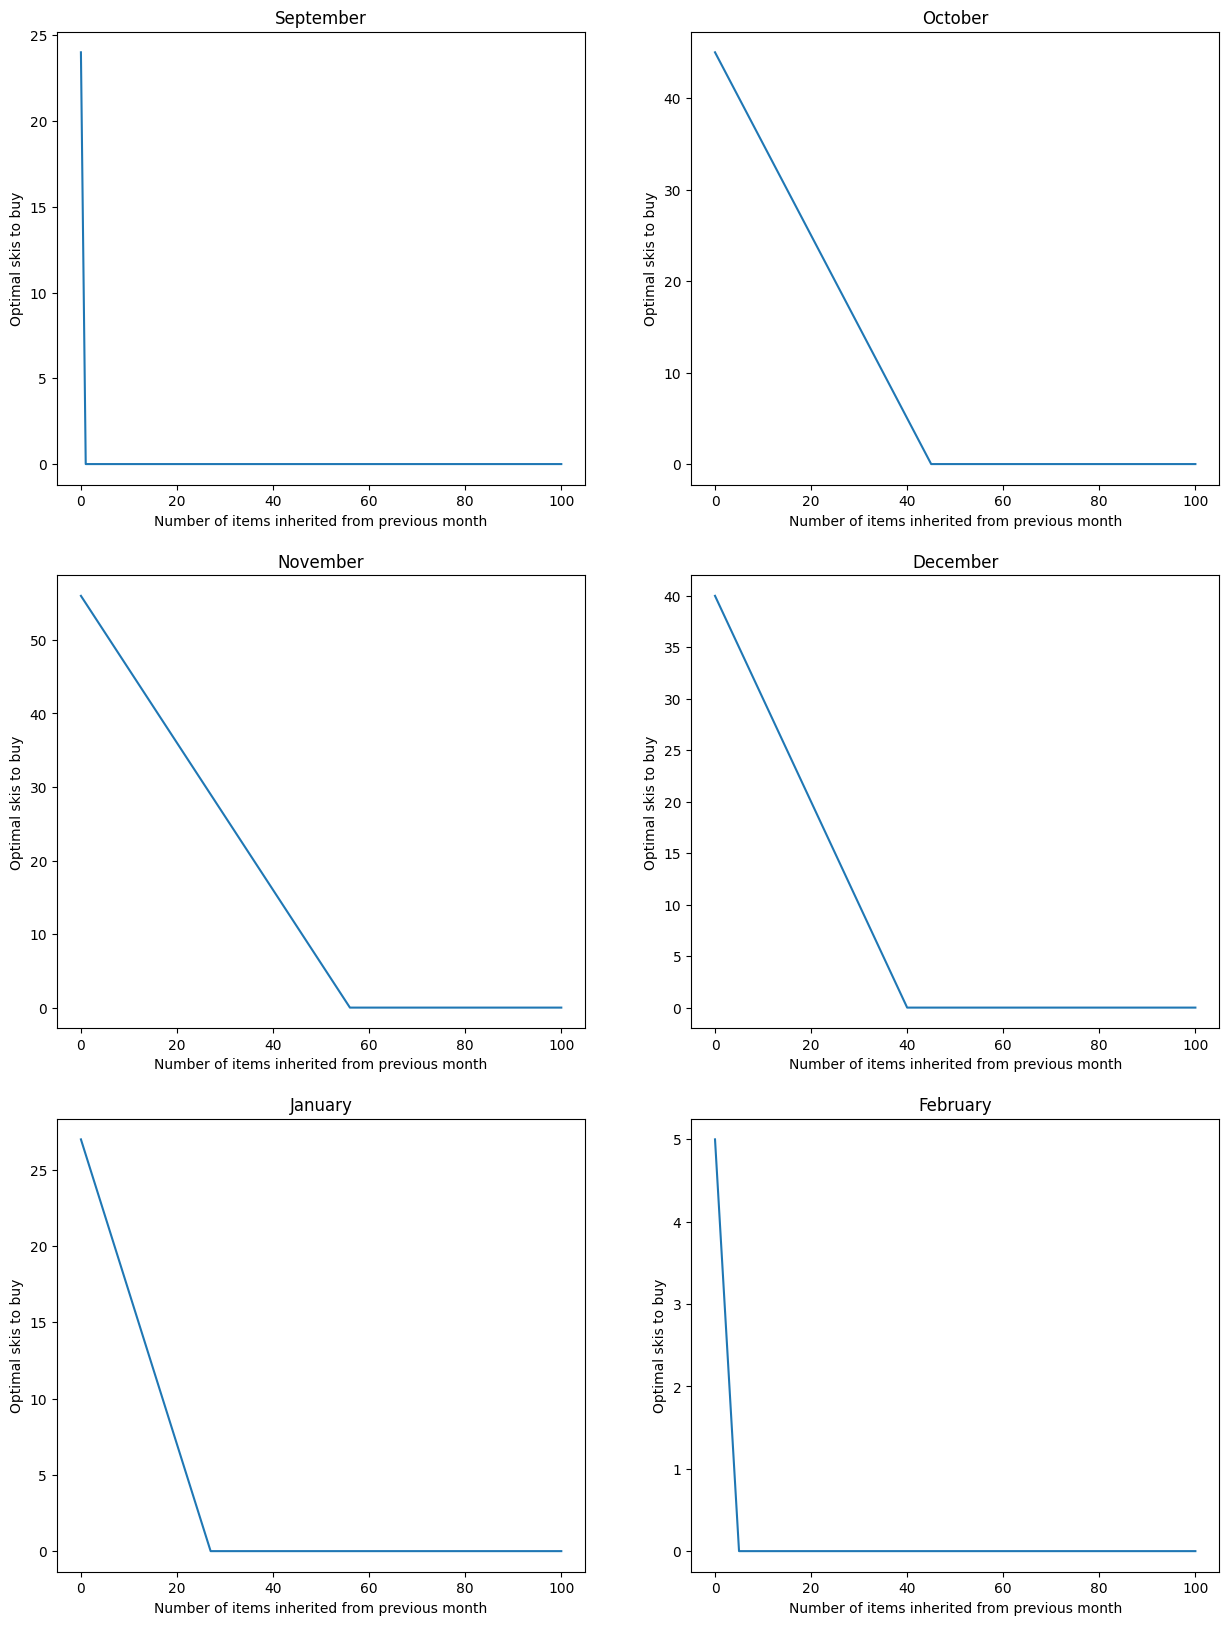

In [323]:
import seaborn as sns
fig, axs = plt.subplots(3, 2, figsize=(15, 20))

sns.lineplot(value_iteration_test.optimal_policy[0], ax = axs[0, 0])
axs[0, 0].set_title('September')
axs[0, 0].set_xlabel('Number of items inherited from previous month')
axs[0, 0].set_ylabel('Optimal skis to buy')

sns.lineplot(value_iteration_test.optimal_policy[1], ax = axs[0, 1])
axs[0, 1].set_title('October')
axs[0, 1].set_xlabel('Number of items inherited from previous month')
axs[0, 1].set_ylabel('Optimal skis to buy')

sns.lineplot(value_iteration_test.optimal_policy[2], ax = axs[1, 0])
axs[1, 0].set_title('November')
axs[1, 0].set_xlabel('Number of items inherited from previous month')
axs[1, 0].set_ylabel('Optimal skis to buy')

sns.lineplot(value_iteration_test.optimal_policy[3], ax = axs[1, 1])
axs[1, 1].set_title('December')
axs[1, 1].set_xlabel('Number of items inherited from previous month')
axs[1, 1].set_ylabel('Optimal skis to buy')

sns.lineplot(value_iteration_test.optimal_policy[4], ax = axs[2, 0])
axs[2, 0].set_title('January')
axs[2, 0].set_xlabel('Number of items inherited from previous month')
axs[2, 0].set_ylabel('Optimal skis to buy')

sns.lineplot(value_iteration_test.optimal_policy[5], ax = axs[2, 1])
axs[2, 1].set_title('February')
axs[2, 1].set_xlabel('Number of items inherited from previous month')
axs[2, 1].set_ylabel('Optimal skis to buy')


#### Question 5c - Simulation of optimal policy

In [327]:
all_returns = []
for i in range(1000):
    all_returns.append(policy_iteration_test.simulate(policy=None))
print(f"Expected Value of rewards: {np.mean(all_returns)}")
print(f"Standard deviation of rewards: {np.std(all_returns)}")

Expected Value of rewards: 26319.763183000003
Standard deviation of rewards: 2166.176655918298


In [326]:
print(f"Value of rewards predicted from algorithm: {policy_iteration_test.state_value[0, 0]}")

Value of rewards predicted from algorithm: 26308.82574338972


The value calculated through the simulation is similar to the value estimated by the algorithm as expected